# Layer & Demographic Comparison Analysis

This notebook provides comprehensive visualizations comparing results across:
- **3 EXAONE layers**: Q1 (25%), Q2 (50%), Q3 (75%)
- **9 demographic dimensions**: 성별, 인종, 종교, 나이, 직업, 학력, 지역, 정치성향, 성적지향

## Visualizations:

1. **Probe Accuracy Comparison**: Linear probe accuracy by layer and demographic
2. **IG² Score Comparison**: Top IG² scores by layer and demographic
3. **Training Loss Comparison**: SAE and probe training curves

## Prerequisites:
- Run pipeline for all 9 demographics and all 3 layers
- Results stored in `results/{stage}/{demographic}/`

In [1]:
import os
import sys
import warnings
import pickle
from pathlib import Path
from collections import defaultdict

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.visualization import ensure_korean_font
from src.utils import load_json

warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier


In [2]:
# Setup Korean font
font_name = ensure_korean_font()

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Font configured: ['DejaVu Sans']


In [3]:
# Configuration
RESULTS_DIR = PROJECT_ROOT / "results"
DATA_DIR = PROJECT_ROOT / "data"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage
STAGE = "full"

# SAE type
SAE_TYPE = "gated"

# Layer quantiles to compare
LAYER_QUANTILES = ["q1", "q2", "q3"]
LAYER_LABELS = {
    "q1": "Layer Q1 (25%)",
    "q2": "Layer Q2 (50%)",
    "q3": "Layer Q3 (75%)"
}

# Load demographics
demo_dict = load_json(DATA_DIR / "demographic_dict_ko.json")
DEMOGRAPHICS = list(demo_dict.keys())
DEMOGRAPHIC_EN = {d: demo_dict[d]['dimension_en'] for d in DEMOGRAPHICS}

print(f"Stage: {STAGE}")
print(f"SAE Type: {SAE_TYPE}")
print(f"Layer Quantiles: {LAYER_QUANTILES}")
print(f"\nDemographics ({len(DEMOGRAPHICS)}):")
for d in DEMOGRAPHICS:
    print(f"  - {d} ({DEMOGRAPHIC_EN[d]})")

Stage: full
SAE Type: gated
Layer Quantiles: ['q1', 'q2', 'q3']

Demographics (9):
  - 성별 (gender)
  - 인종 (ethnicity)
  - 종교 (religion)
  - 성적지향 (sexuality)
  - 나이 (age)
  - 외모 (physical appearance)
  - 경제수준 (socioeconomic status)
  - 정치성향 (politics)
  - 직업 (occupation)


---
## Data Loading Functions

In [4]:
def load_probe_results(results_dir, stage, demographic, layer_quantile):
    """
    Load linear probe training results.
    
    Returns:
        dict with 'accuracy', 'best_accuracy', 'losses', etc.
        or None if not found
    """
    # Try per-demographic directory first
    probe_path = results_dir / stage / demographic / 'probe' / 'linear_probe.pt'
    metrics_path = results_dir / stage / demographic / 'probe' / 'training_metrics.pkl'
    
    if not probe_path.exists():
        return None
    
    result = {}
    
    # Load probe checkpoint
    checkpoint = torch.load(probe_path, map_location='cpu')
    result['final_accuracy'] = checkpoint.get('final_accuracy', 0)
    result['best_accuracy'] = checkpoint.get('best_accuracy', 0)
    result['layer_quantile'] = checkpoint.get('layer_quantile', layer_quantile)
    
    # Load training metrics if available
    if metrics_path.exists():
        with open(metrics_path, 'rb') as f:
            metrics = pickle.load(f)
        result['losses'] = metrics.get('losses', [])
        result['accuracies'] = metrics.get('accuracies', [])
    
    return result


def load_ig2_results(results_dir, stage, demographic, layer_quantile):
    """
    Load IG² attribution results.
    
    Returns:
        dict with 'feature_scores', 'top_features', etc.
        or None if not found
    """
    ig2_path = results_dir / stage / demographic / 'ig2' / 'ig2_results.pt'
    
    if not ig2_path.exists():
        raise FileNotFoundError(f"IG² results not found: {ig2_path}")
    
    data = torch.load(ig2_path, map_location='cpu')
    return data


def load_sae_training_logs(results_dir, stage, sae_type, layer_quantile):
    """
    Load SAE training logs.
    
    Returns:
        pandas DataFrame with training logs
        or None if not found
    """
    log_path = results_dir / "models" / f"sae-{sae_type}_{stage}_{layer_quantile}" / "training_logs.csv"
    
    if not log_path.exists():
        return None
    
    return pd.read_csv(log_path)


print("Data loading functions defined.")

Data loading functions defined.


In [5]:
# Scan for available results
available_results = defaultdict(lambda: defaultdict(dict))

print("Scanning for available results...\n")

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        # Check probe results
        probe_results = load_probe_results(RESULTS_DIR, STAGE, demo, lq)
        if probe_results:
            available_results[demo][lq]['probe'] = probe_results
        
        # Check IG2 results
        ig2_results = load_ig2_results(RESULTS_DIR, STAGE, demo, lq)
        if ig2_results:
            available_results[demo][lq]['ig2'] = ig2_results

# Check SAE training logs (SAE is shared across demographics)
sae_logs = {}
for lq in LAYER_QUANTILES:
    logs = load_sae_training_logs(RESULTS_DIR, STAGE, SAE_TYPE, lq)
    if logs is not None:
        sae_logs[lq] = logs

# Summary
print("Available Results Summary:")
print("=" * 70)
print(f"{'Demographic':<15} | {'Q1 (25%)':<15} | {'Q2 (50%)':<15} | {'Q3 (75%)':<15}")
print("-" * 70)

for demo in DEMOGRAPHICS:
    row = f"{demo:<15} |"
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            has_probe = 'probe' in available_results[demo][lq]
            has_ig2 = 'ig2' in available_results[demo][lq]
            status = f"P:{'+' if has_probe else '-'} I:{'+' if has_ig2 else '-'}"
        else:
            status = "--"
        row += f" {status:<14}|"
    print(row)

print("-" * 70)
print(f"\nSAE Training Logs: {', '.join(sae_logs.keys()) if sae_logs else 'None'}")

Scanning for available results...

Available Results Summary:
Demographic     | Q1 (25%)        | Q2 (50%)        | Q3 (75%)       
----------------------------------------------------------------------
성별              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
인종              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
종교              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
성적지향            | P:+ I:+       | P:+ I:+       | P:+ I:+       |
나이              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
외모              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
경제수준            | P:+ I:+       | P:+ I:+       | P:+ I:+       |
정치성향            | P:+ I:+       | P:+ I:+       | P:+ I:+       |
직업              | P:+ I:+       | P:+ I:+       | P:+ I:+       |
----------------------------------------------------------------------

SAE Training Logs: q1, q2, q3


---
## 1. Probe Accuracy Comparison

Visualize linear probe accuracy (gSAE + Linear Probe) across:
- Different EXAONE layers (Q1, Q2, Q3)
- Different demographic dimensions

In [6]:
# Collect accuracy data
accuracy_data = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            if 'probe' in available_results[demo][lq]:
                probe = available_results[demo][lq]['probe']
                accuracy_data.append({
                    'Demographic': demo,
                    'Demographic_EN': DEMOGRAPHIC_EN[demo],
                    'Layer': LAYER_LABELS[lq],
                    'Layer_Quantile': lq,
                    'Final_Accuracy': probe['final_accuracy'],
                    'Best_Accuracy': probe['best_accuracy']
                })

df_accuracy = pd.DataFrame(accuracy_data)

if len(df_accuracy) > 0:
    print(f"Collected accuracy data for {len(df_accuracy)} experiments")
    print(df_accuracy.head(10))
else:
    print("No accuracy data found. Please run the training pipeline first.")

Collected accuracy data for 27 experiments
  Demographic Demographic_EN           Layer Layer_Quantile  Final_Accuracy  \
0          성별         gender  Layer Q1 (25%)             q1             1.0   
1          성별         gender  Layer Q2 (50%)             q2             1.0   
2          성별         gender  Layer Q3 (75%)             q3             1.0   
3          인종      ethnicity  Layer Q1 (25%)             q1             1.0   
4          인종      ethnicity  Layer Q2 (50%)             q2             1.0   
5          인종      ethnicity  Layer Q3 (75%)             q3             1.0   
6          종교       religion  Layer Q1 (25%)             q1             1.0   
7          종교       religion  Layer Q2 (50%)             q2             1.0   
8          종교       religion  Layer Q3 (75%)             q3             1.0   
9        성적지향      sexuality  Layer Q1 (25%)             q1             1.0   

   Best_Accuracy  
0            1.0  
1            1.0  
2            1.0  
3          

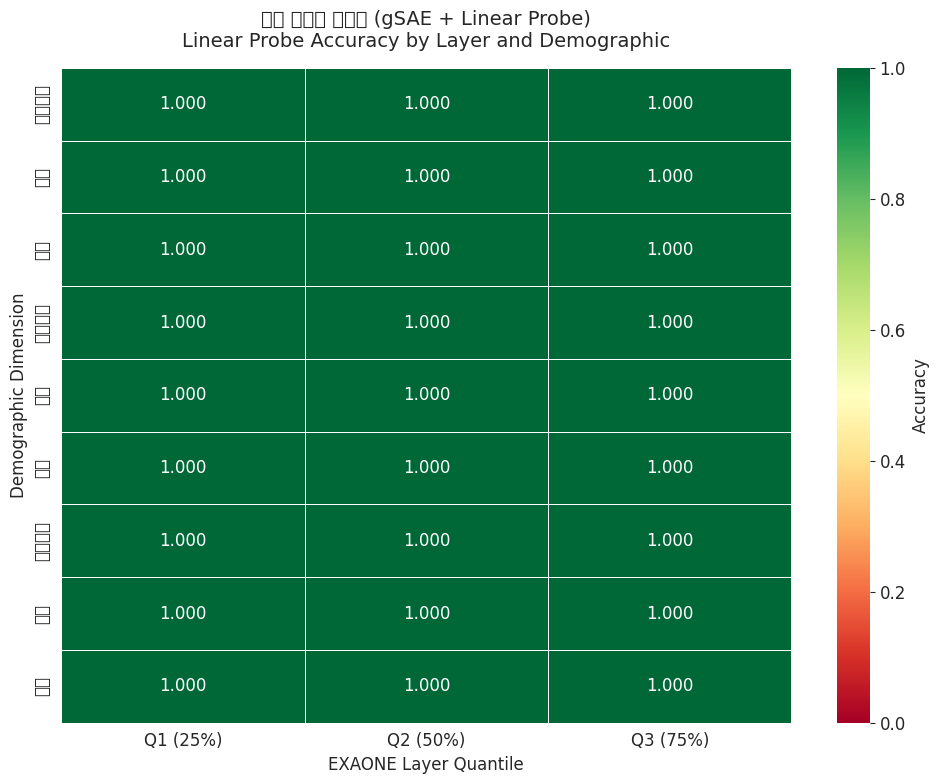


Accuracy Statistics:

Layer Q1 (25%):
  Mean Accuracy:   1.000
  Std Accuracy:    0.000
  Min Accuracy:    1.000
  Max Accuracy:    1.000

Layer Q2 (50%):
  Mean Accuracy:   1.000
  Std Accuracy:    0.000
  Min Accuracy:    1.000
  Max Accuracy:    1.000

Layer Q3 (75%):
  Mean Accuracy:   1.000
  Std Accuracy:    0.000
  Min Accuracy:    1.000
  Max Accuracy:    1.000


In [7]:
if len(df_accuracy) > 0:
    # Create heatmap of accuracy by demographic and layer
    pivot_acc = df_accuracy.pivot(index='Demographic', columns='Layer_Quantile', values='Best_Accuracy')
    
    # Reorder columns
    pivot_acc = pivot_acc[['q1', 'q2', 'q3']]
    pivot_acc.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        pivot_acc,
        annot=True,
        fmt='.3f',
        cmap='RdYlGn',
        vmin=0.0,
        vmax=1.0,
        ax=ax,
        cbar_kws={'label': 'Accuracy'},
        linewidths=0.5
    )
    
    ax.set_title('선형 프로브 정확도 (gSAE + Linear Probe)\nLinear Probe Accuracy by Layer and Demographic', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer Quantile', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"probe_accuracy_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nAccuracy Statistics:")
    print("=" * 60)
    for lq in ['q1', 'q2', 'q3']:
        lq_data = df_accuracy[df_accuracy['Layer_Quantile'] == lq]
        if len(lq_data) > 0:
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Mean Accuracy:   {lq_data['Best_Accuracy'].mean():.3f}")
            print(f"  Std Accuracy:    {lq_data['Best_Accuracy'].std():.3f}")
            print(f"  Min Accuracy:    {lq_data['Best_Accuracy'].min():.3f}")
            print(f"  Max Accuracy:    {lq_data['Best_Accuracy'].max():.3f}")

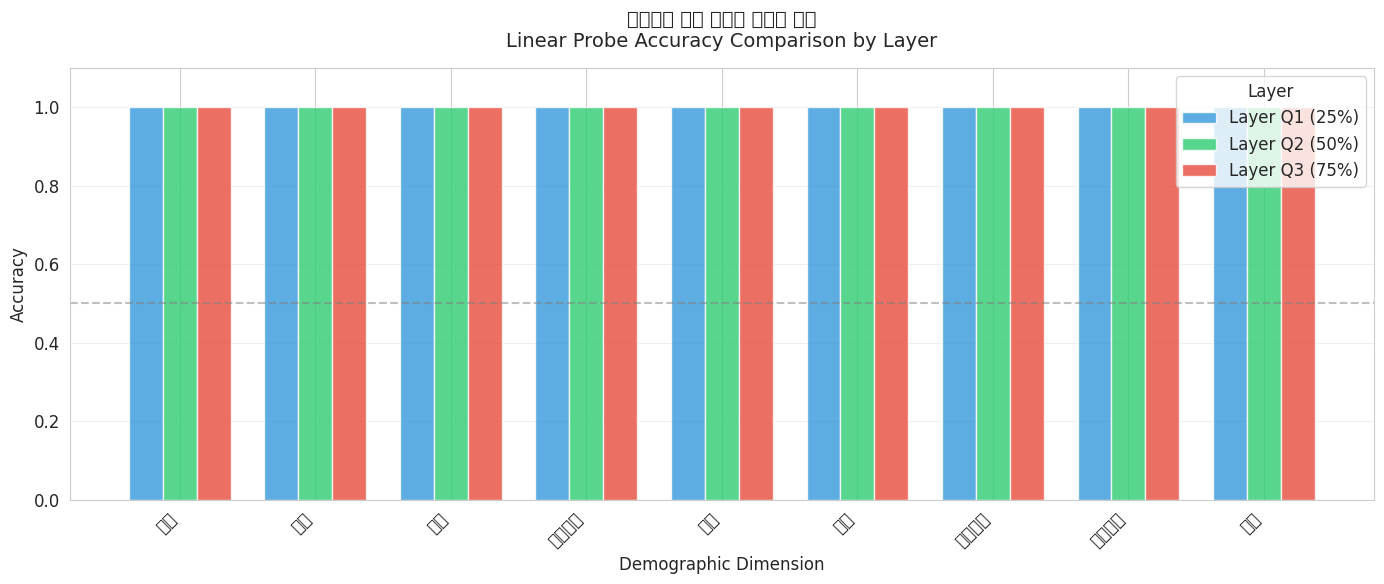

In [8]:
if len(df_accuracy) > 0:
    # Grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(DEMOGRAPHICS))
    width = 0.25
    
    colors = ['#3498db', '#2ecc71', '#e74c3c']  # Blue, Green, Red
    
    for i, lq in enumerate(LAYER_QUANTILES):
        lq_data = df_accuracy[df_accuracy['Layer_Quantile'] == lq]
        
        # Get accuracy for each demographic (in order)
        accuracies = []
        for demo in DEMOGRAPHICS:
            demo_data = lq_data[lq_data['Demographic'] == demo]
            if len(demo_data) > 0:
                accuracies.append(demo_data['Best_Accuracy'].values[0])
            else:
                accuracies.append(0)
        
        ax.bar(x + i * width, accuracies, width, label=LAYER_LABELS[lq], color=colors[i], alpha=0.8)
    
    ax.set_xlabel('Demographic Dimension', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('레이어별 선형 프로브 정확도 비교\nLinear Probe Accuracy Comparison by Layer', fontsize=14, pad=15)
    ax.set_xticks(x + width)
    ax.set_xticklabels(DEMOGRAPHICS, rotation=45, ha='right')
    ax.legend(title='Layer', loc='upper right')
    ax.set_ylim(0, 1.1)
    ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Random (50%)')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"probe_accuracy_bars_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

---
## 2. IG² Score Comparison

Compare IG² attribution scores across layers and demographics.
This shows which SAE neurons are most important for bias prediction.

In [9]:
# Collect IG² statistics
ig2_stats = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            if 'ig2' in available_results[demo][lq]:
                ig2_data = available_results[demo][lq]['ig2']
                
                # Get feature scores
                if isinstance(ig2_data, dict):
                    scores = ig2_data.get('feature_scores', ig2_data.get('ig2_scores', None))
                else:
                    scores = ig2_data
                
                if scores is not None:
                    if isinstance(scores, torch.Tensor):
                        scores = scores.cpu().numpy()
                    
                    # Compute statistics
                    top_10 = np.sort(scores)[-10:]
                    top_50 = np.sort(scores)[-50:]
                    top_100 = np.sort(scores)[-100:]
                    
                    ig2_stats.append({
                        'Demographic': demo,
                        'Demographic_EN': DEMOGRAPHIC_EN[demo],
                        'Layer': LAYER_LABELS[lq],
                        'Layer_Quantile': lq,
                        'Max_Score': scores.max(),
                        'Top10_Mean': top_10.mean(),
                        'Top50_Mean': top_50.mean(),
                        'Top100_Mean': top_100.mean(),
                        'Total_Nonzero': (scores > 0).sum(),
                        'Scores': scores  # Keep for detailed analysis
                    })

df_ig2 = pd.DataFrame(ig2_stats)

if len(df_ig2) > 0:
    print(f"Collected IG² data for {len(df_ig2)} experiments")
    print(df_ig2[['Demographic', 'Layer_Quantile', 'Max_Score', 'Top10_Mean', 'Total_Nonzero']].head(10))
else:
    print("No IG² data found. Please run the IG² computation pipeline first.")

Collected IG² data for 27 experiments
  Demographic Layer_Quantile  Max_Score  Top10_Mean  Total_Nonzero
0          성별             q1   0.410833    0.284238            642
1          성별             q2   0.410833    0.284238            642
2          성별             q3   0.410833    0.284238            642
3          인종             q1   0.519620    0.330499           1043
4          인종             q2   0.519620    0.330499           1043
5          인종             q3   0.519620    0.330499           1043
6          종교             q1   0.496713    0.325922            529
7          종교             q2   0.496713    0.325922            529
8          종교             q3   0.496713    0.325922            529
9        성적지향             q1   0.451268    0.264377            446


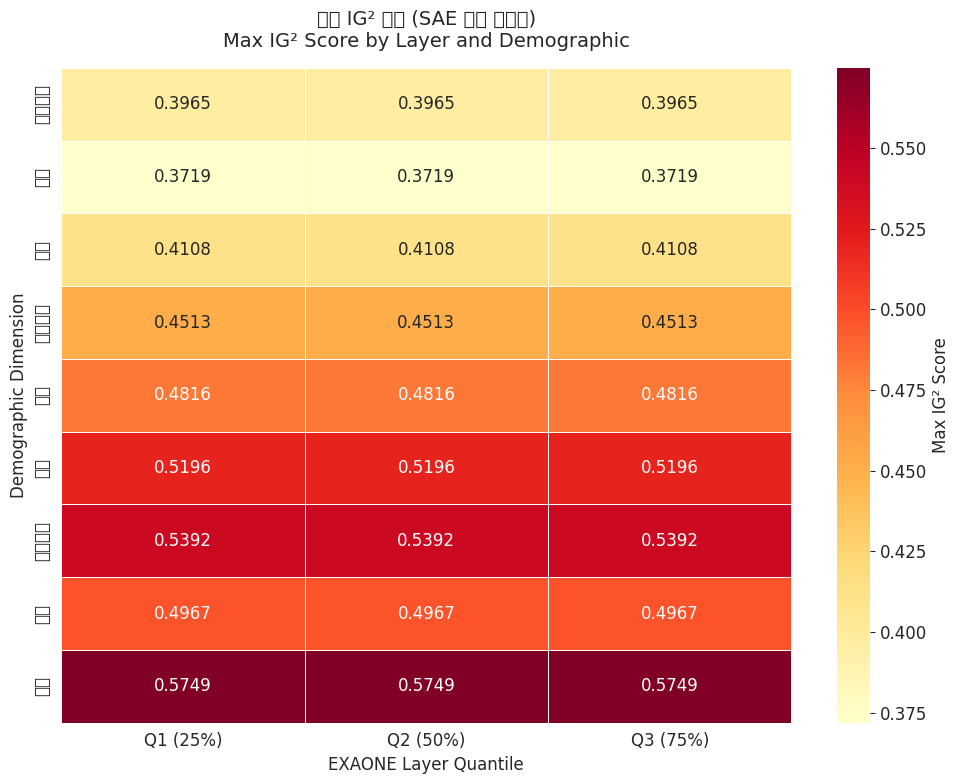

In [10]:
if len(df_ig2) > 0:
    # Heatmap of max IG² scores
    pivot_ig2 = df_ig2.pivot(index='Demographic', columns='Layer_Quantile', values='Max_Score')
    pivot_ig2 = pivot_ig2[['q1', 'q2', 'q3']]
    pivot_ig2.columns = ['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.heatmap(
        pivot_ig2,
        annot=True,
        fmt='.4f',
        cmap='YlOrRd',
        ax=ax,
        cbar_kws={'label': 'Max IG² Score'},
        linewidths=0.5
    )
    
    ax.set_title('최대 IG² 점수 (SAE 뉴런 중요도)\nMax IG² Score by Layer and Demographic', 
                 fontsize=14, pad=15)
    ax.set_xlabel('EXAONE Layer Quantile', fontsize=12)
    ax.set_ylabel('Demographic Dimension', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"ig2_max_scores_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

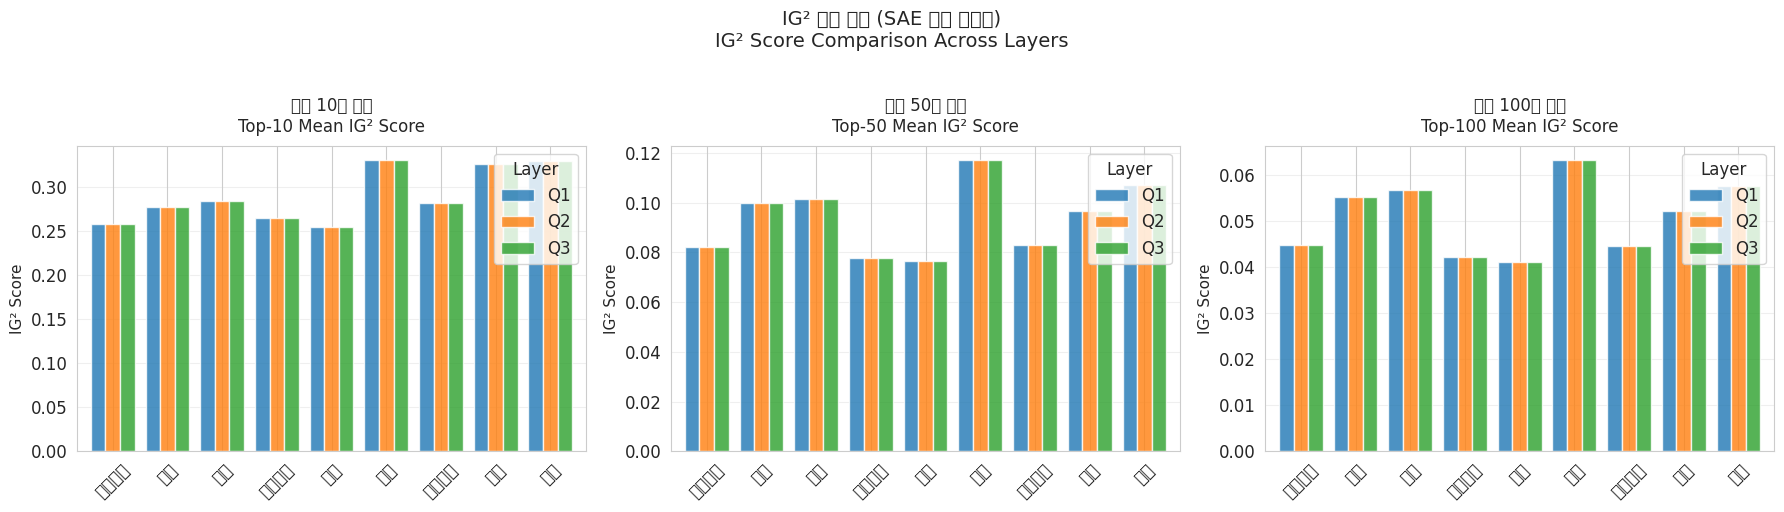

In [11]:
if len(df_ig2) > 0:
    # Top-K mean IG² scores comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    metrics = ['Top10_Mean', 'Top50_Mean', 'Top100_Mean']
    titles = ['Top-10 Mean IG² Score', 'Top-50 Mean IG² Score', 'Top-100 Mean IG² Score']
    titles_ko = ['상위 10개 평균', '상위 50개 평균', '상위 100개 평균']
    
    for idx, (metric, title, title_ko) in enumerate(zip(metrics, titles, titles_ko)):
        ax = axes[idx]
        
        pivot = df_ig2.pivot(index='Demographic', columns='Layer_Quantile', values=metric)
        pivot = pivot[['q1', 'q2', 'q3']]
        pivot.columns = ['Q1', 'Q2', 'Q3']
        
        pivot.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
        ax.set_title(f'{title_ko}\n{title}', fontsize=12, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('IG² Score', fontsize=11)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Layer', loc='upper right')
        ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('IG² 점수 비교 (SAE 뉴런 중요도)\nIG² Score Comparison Across Layers', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"ig2_topk_comparison_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

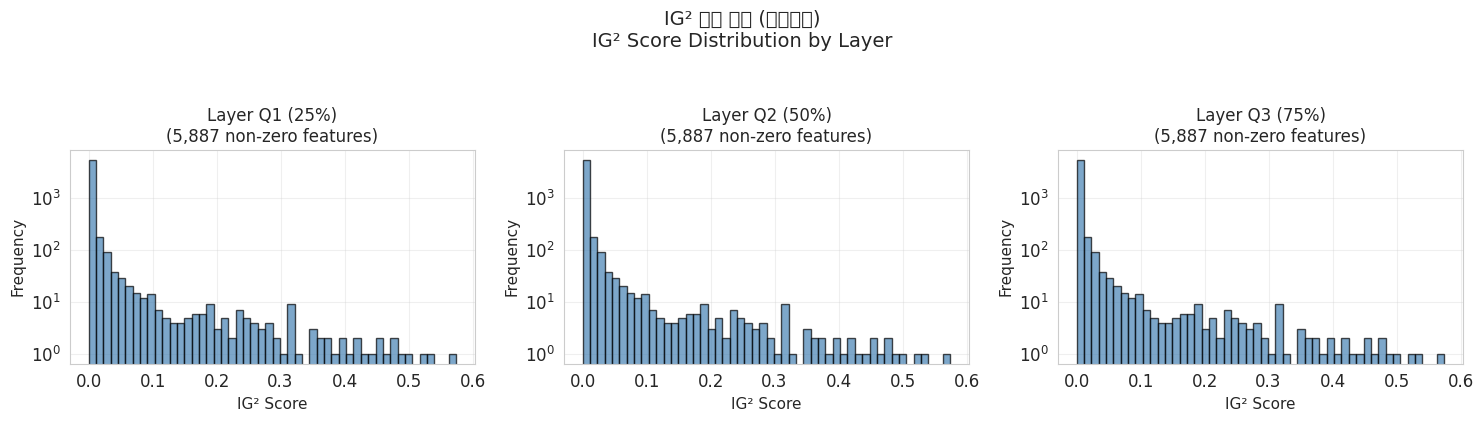

In [12]:
if len(df_ig2) > 0:
    # Distribution of IG² scores for each layer (aggregated across demographics)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, lq in enumerate(LAYER_QUANTILES):
        ax = axes[idx]
        
        lq_data = df_ig2[df_ig2['Layer_Quantile'] == lq]
        
        if len(lq_data) > 0:
            # Concatenate all scores for this layer
            all_scores = np.concatenate([row['Scores'] for _, row in lq_data.iterrows()])
            
            # Plot histogram (only positive scores)
            positive_scores = all_scores[all_scores > 0]
            ax.hist(positive_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax.set_xlabel('IG² Score', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{LAYER_LABELS[lq]}\n({len(positive_scores):,} non-zero features)', fontsize=12)
            ax.set_yscale('log')
            ax.grid(alpha=0.3)
    
    plt.suptitle('IG² 점수 분포 (레이어별)\nIG² Score Distribution by Layer', fontsize=14, y=1.05)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"ig2_distribution_by_layer_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()

---
## 3. Training Loss Comparison

Compare training dynamics:
- SAE training loss by layer
- Linear probe training loss by demographic and layer

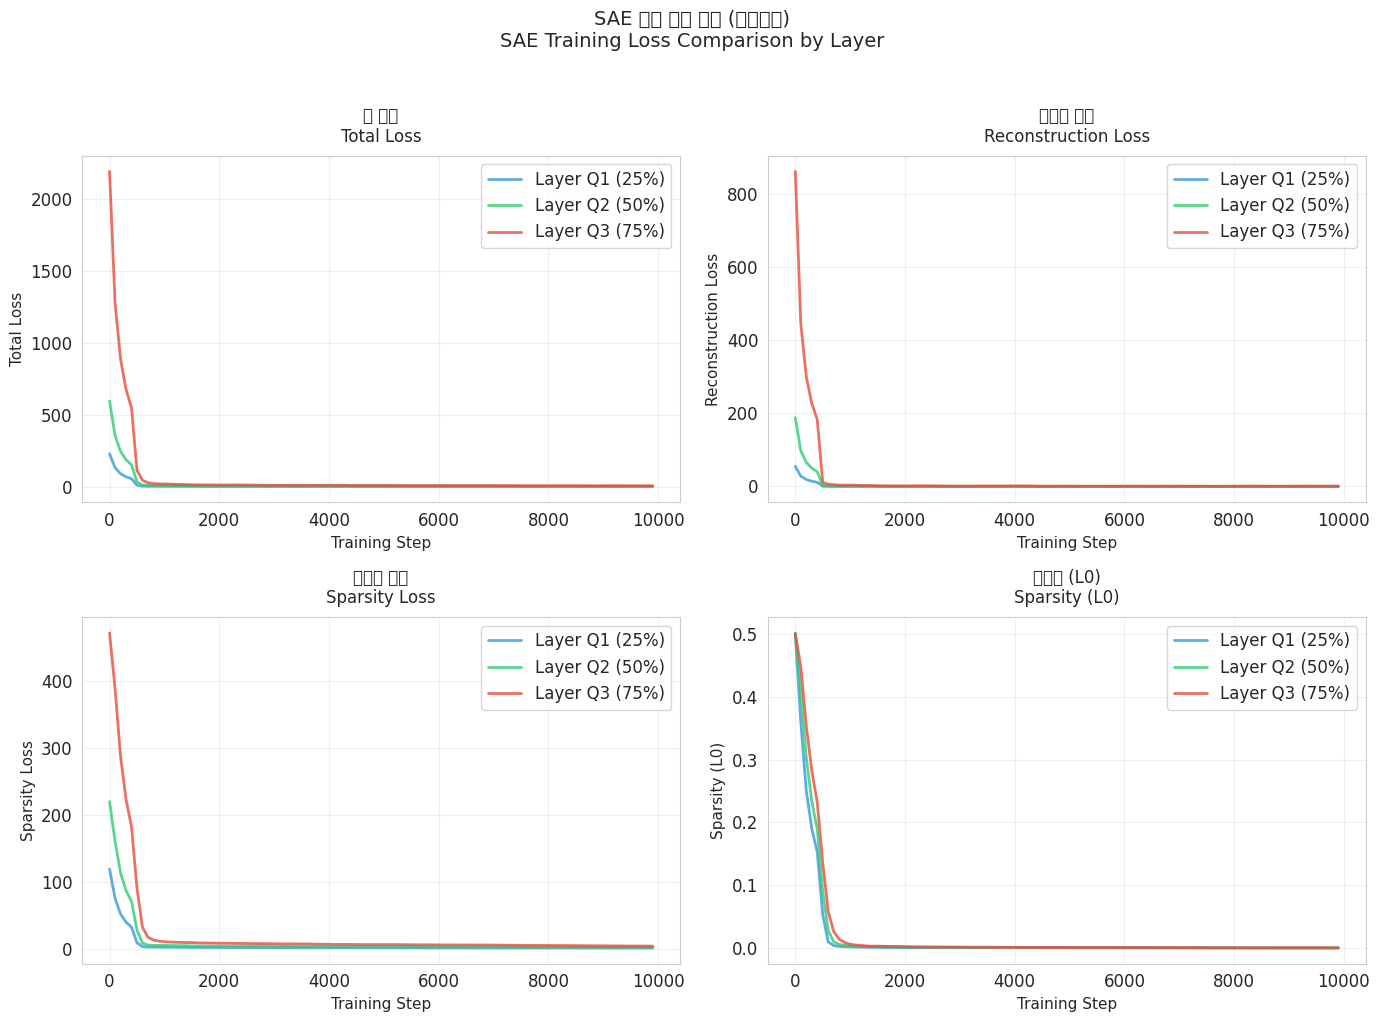


SAE Final Training Statistics:

Layer Q1 (25%):
  Total Steps: 100
  Final Total Loss: 0.9040
  Final Recon Loss: 0.0507
  Final Sparsity L0: 0.0001

Layer Q2 (50%):
  Total Steps: 100
  Final Total Loss: 2.0305
  Final Recon Loss: 0.1855
  Final Sparsity L0: 0.0003

Layer Q3 (75%):
  Total Steps: 100
  Final Total Loss: 5.4926
  Final Recon Loss: 0.9526
  Final Sparsity L0: 0.0004


In [13]:
# SAE Training Loss Comparison
if sae_logs:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    metrics = ['total_loss', 'recon_loss', 'sparsity_loss', 'sparsity_l0']
    titles = ['Total Loss', 'Reconstruction Loss', 'Sparsity Loss', 'Sparsity (L0)']
    titles_ko = ['총 손실', '재구성 손실', '희소성 손실', '희소성 (L0)']
    
    colors = {'q1': '#3498db', 'q2': '#2ecc71', 'q3': '#e74c3c'}
    
    for idx, (metric, title, title_ko) in enumerate(zip(metrics, titles, titles_ko)):
        ax = axes[idx]
        
        for lq in LAYER_QUANTILES:
            if lq in sae_logs and metric in sae_logs[lq].columns:
                logs = sae_logs[lq]
                # Smooth the curve
                window = max(1, len(logs) // 20)
                smoothed = logs[metric].rolling(window=window, min_periods=1).mean()
                ax.plot(logs['step'], smoothed, label=LAYER_LABELS[lq], 
                       color=colors[lq], linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Training Step', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.set_title(f'{title_ko}\n{title}', fontsize=12, pad=10)
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3)
    
    plt.suptitle('SAE 학습 손실 비교 (레이어별)\nSAE Training Loss Comparison by Layer', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"sae_training_loss_comparison_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Final statistics
    print("\nSAE Final Training Statistics:")
    print("=" * 70)
    for lq in LAYER_QUANTILES:
        if lq in sae_logs:
            logs = sae_logs[lq]
            print(f"\n{LAYER_LABELS[lq]}:")
            print(f"  Total Steps: {len(logs)}")
            print(f"  Final Total Loss: {logs['total_loss'].iloc[-1]:.4f}")
            print(f"  Final Recon Loss: {logs['recon_loss'].iloc[-1]:.4f}")
            print(f"  Final Sparsity L0: {logs['sparsity_l0'].iloc[-1]:.4f}")
else:
    print("No SAE training logs found.")

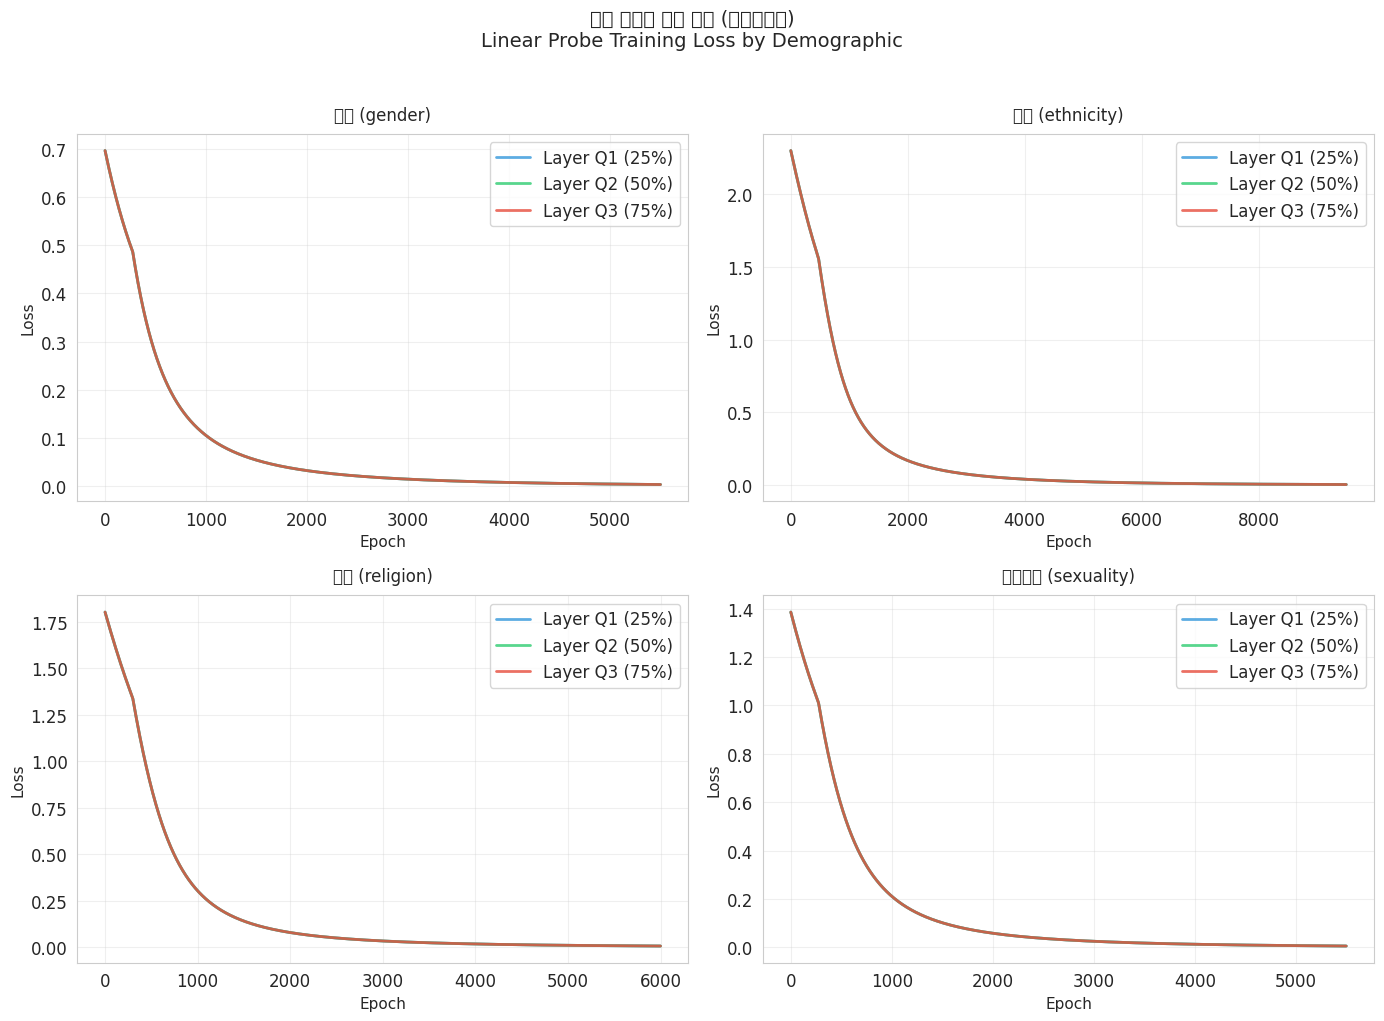

In [14]:
# Linear Probe Training Loss by Demographic
probe_losses = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        if demo in available_results and lq in available_results[demo]:
            if 'probe' in available_results[demo][lq]:
                probe = available_results[demo][lq]['probe']
                if 'losses' in probe and len(probe['losses']) > 0:
                    probe_losses.append({
                        'Demographic': demo,
                        'Layer_Quantile': lq,
                        'Losses': probe['losses'],
                        'Accuracies': probe.get('accuracies', [])
                    })

if probe_losses:
    # Select subset of demographics for clarity
    demo_subset = DEMOGRAPHICS[:4] if len(DEMOGRAPHICS) > 4 else DEMOGRAPHICS
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = {'q1': '#3498db', 'q2': '#2ecc71', 'q3': '#e74c3c'}
    
    for idx, demo in enumerate(demo_subset):
        ax = axes[idx]
        
        for lq in LAYER_QUANTILES:
            matching = [p for p in probe_losses if p['Demographic'] == demo and p['Layer_Quantile'] == lq]
            if matching:
                losses = matching[0]['Losses']
                # Smooth
                window = max(1, len(losses) // 20)
                smoothed = pd.Series(losses).rolling(window=window, min_periods=1).mean()
                ax.plot(smoothed, label=LAYER_LABELS[lq], color=colors[lq], linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Epoch', fontsize=11)
        ax.set_ylabel('Loss', fontsize=11)
        ax.set_title(f'{demo} ({DEMOGRAPHIC_EN[demo]})', fontsize=12, pad=10)
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3)
    
    plt.suptitle('선형 프로브 학습 손실 (인구통계별)\nLinear Probe Training Loss by Demographic', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"probe_training_loss_by_demo_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No probe training loss data found.")

---
## Summary Statistics Table

In [15]:
# Create comprehensive summary table
summary_data = []

for demo in DEMOGRAPHICS:
    for lq in LAYER_QUANTILES:
        row = {
            'Demographic': demo,
            'Layer': lq,
            'Probe_Accuracy': None,
            'IG2_Max': None,
            'IG2_Top10_Mean': None,
        }
        
        if demo in available_results and lq in available_results[demo]:
            if 'probe' in available_results[demo][lq]:
                row['Probe_Accuracy'] = available_results[demo][lq]['probe']['best_accuracy']
            
            if 'ig2' in available_results[demo][lq]:
                ig2_row = df_ig2[(df_ig2['Demographic'] == demo) & (df_ig2['Layer_Quantile'] == lq)]
                if len(ig2_row) > 0:
                    row['IG2_Max'] = ig2_row['Max_Score'].values[0]
                    row['IG2_Top10_Mean'] = ig2_row['Top10_Mean'].values[0]
        
        summary_data.append(row)

df_summary = pd.DataFrame(summary_data)

print("\n" + "=" * 80)
print("COMPREHENSIVE SUMMARY TABLE")
print("=" * 80)
print(df_summary.to_string(index=False))

# Save to CSV
df_summary.to_csv(ASSETS_DIR / f"layer_demographic_summary_{STAGE}.csv", index=False)
print(f"\nSaved summary to: {ASSETS_DIR / f'layer_demographic_summary_{STAGE}.csv'}")


COMPREHENSIVE SUMMARY TABLE
Demographic Layer  Probe_Accuracy  IG2_Max  IG2_Top10_Mean
         성별    q1             1.0 0.410833        0.284238
         성별    q2             1.0 0.410833        0.284238
         성별    q3             1.0 0.410833        0.284238
         인종    q1             1.0 0.519620        0.330499
         인종    q2             1.0 0.519620        0.330499
         인종    q3             1.0 0.519620        0.330499
         종교    q1             1.0 0.496713        0.325922
         종교    q2             1.0 0.496713        0.325922
         종교    q3             1.0 0.496713        0.325922
       성적지향    q1             1.0 0.451268        0.264377
       성적지향    q2             1.0 0.451268        0.264377
       성적지향    q3             1.0 0.451268        0.264377
         나이    q1             1.0 0.371879        0.277218
         나이    q2             1.0 0.371879        0.277218
         나이    q3             1.0 0.371879        0.277218
         외모    q1          

---
## Key Findings & Interpretation

### 1. Probe Accuracy Analysis
- **Which layer works best?** Compare Q1, Q2, Q3 accuracy
- **Which demographics are easier/harder?** Check accuracy variance
- **Is middle layer (Q2) generally best?** Common finding in interpretability research

### 2. IG² Score Analysis
- **Which layer has strongest bias features?** Higher IG² = more important features
- **Are bias features shared or unique?** Compare top features across demographics
- **Does importance vary by layer?** Earlier vs. later layer patterns

### 3. Training Dynamics
- **Do all layers converge similarly?** Compare loss curves
- **Any layer-specific training issues?** Check for instability
- **Sparsity target achieved?** Verify L0 targets

### Recommendations
1. **Best layer for bias detection**: Typically Q2 (middle)
2. **Feature selection**: Use IG² top-K from best performing layer
3. **Robustness check**: Verify findings hold across multiple layers